In [1]:
from gensim.models.word2vec import Word2Vec
import numpy as np

import urllib3
import pandas as pd
import os
import gc
import tensorflow as tf
from keras.preprocessing import text, sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.layers import GRU, Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from IPython.core.display import display, HTML
display(HTML("<style>.container { width: 100% !important; }</style>"))

C:\Users\gusals\anaconda3\envs\deep2\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
train=pd.read_csv('./data/train.csv')/
test=pd.read_csv('./data/test.csv')
submission=pd.read_csv('./data/sample_submission.csv')

In [844]:
train = pd.read_csv('./data/mask_test2/mask_train.csv')

In [845]:
train

,id,level,full_log,pre_log,first
0,0,0,"Sep 24 10:02:22 localhost kibana: {""type"":""err...",Sep localhost kibana type error timestamp Z ta...,...
1,1,0,Feb 8 16:21:00 localhost logstash: [2021-02-0...,Feb localhost logstash INFO logstash outputs e...,...
2,2,0,"Jan 13 01:50:40 localhost kibana: {""type"":""err...",Jan localhost kibana type error timestamp Z ta...,...
3,3,0,"Jan 4 10:18:31 localhost kibana: {""type"":""err...",Jan localhost kibana type error timestamp Z ta...,...
4,4,1,type=SYSCALL msg=audit(1603094402.016:52981): ...,type SYSCALL msg audit arch syscall success ye...,...
...,...,...,...,...,...
472967,472967,0,Feb 28 10:10:06 localhost logstash: 7738 error:,Feb localhost logstash error,
472968,472968,1,type=SYSCALL msg=audit(1611890993.458:321827):...,type SYSCALL msg audit arch syscall success ye...,...
472969,472969,0,"Oct 12 02:20:29 localhost kibana: {""type"":""log...",Oct localhost kibana type log timestamp Z tags...,
472970,472970,0,"Jan 15 09:02:43 localhost kibana: {""type"":""err...",Jan localhost kibana type error timestamp Z ta...,...


In [847]:
train['pre_log'][0]

'Sep localhost kibana type error timestamp Z tags warning stats collection pid level error error message No Living connections name Error stack Error No Living connections at sendReqWithConnection usr share kibana node modules elasticsearch src lib transport js at next usr share kibana node modules elasticsearch src lib connection pool js at process tickCallback internal process next tick js message No Living connections '

In [848]:
print(train.shape, test.shape, submission.shape)

(472972, 5) (1418916, 4) (1418916, 2)


In [849]:
# #full_log에서 숫자는 마스킹 처리
# train['full_log']=train['full_log'].str.replace(r'[0-9]', '<num>')
# test['full_log']=test['full_log'].str.replace(r'[0-9]', '<num>')

In [850]:
# #train full_log의 길이 확인
# train['full_log'].str.split(' ').str.len().hist(bins=50)

In [851]:
# train['level'].value_counts()

In [852]:
# train_text=list(train['full_log'][train['level'].isin([0,1])])
# train_level=np.array(train['level'][train['level'].isin([0,1])])

In [973]:
train_text=list(train['pre_log'][train['level'].isin([0])])
train_level=np.array(train['level'][train['level'].isin([0])])

In [974]:
# train_text=list(train['first'])
# train_level=np.array(train['level'])

In [975]:
# import re

# for i in train_text:
#     i = re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]', '', i)
# #     i = i.replace('Jan', '')
# #     i = i.replace('Feb', '')
# #     i = i.replace('Dec', '')
# #     i = i.replace('Sep', '')
# #     i = i.replace('Oct', '')
# #     i = i.replace('Nov', '')
# #     i = i.replace('Mar', '')
# #     i = i.sub('num', '', i)

In [976]:
maxlen = 100
embed_size = 30
max_features = 100

In [977]:
# #CountVectorizer로 벡터화
# from sklearn.feature_extraction.text import CountVectorizer
# vectorizer=CountVectorizer(analyzer="word", max_features=500)

# train_features=vectorizer.fit_transform(train_text)

In [978]:
# train_features

In [979]:
tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(train_text)

In [980]:
sequences = tokenizer.texts_to_sequences(train_text)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 4050 unique tokens.


In [981]:
word_index

{'error': 1,
 'elasticsearch': 2,
 'kibana': 3,
 'localhost': 4,
 'no': 5,
 'connections': 6,
 'living': 7,
 'at': 8,
 'js': 9,
 'message': 10,
 'logstash': 11,
 'type': 12,
 'node': 13,
 'modules': 14,
 'usr': 15,
 'share': 16,
 'lib': 17,
 'src': 18,
 'to': 19,
 'process': 20,
 'next': 21,
 'connection': 22,
 'jan': 23,
 'pool': 24,
 'timestamp': 25,
 'z': 26,
 'pid': 27,
 'tags': 28,
 'outputs': 29,
 'warning': 30,
 'transport': 31,
 'internal': 32,
 'tickcallback': 33,
 'tick': 34,
 'sendreqwithconnection': 35,
 'name': 36,
 'level': 37,
 'stats': 38,
 'stack': 39,
 'collection': 40,
 'http': 41,
 'failed': 42,
 'log': 43,
 'unreachable': 44,
 'httpclient': 45,
 'the': 46,
 'attempted': 47,
 'but': 48,
 'task': 49,
 'an': 50,
 'for': 51,
 'warn': 52,
 'manager': 53,
 'hostunreachableerror': 54,
 'manticore': 55,
 'url': 56,
 'dead': 57,
 'socketexception': 58,
 'instance': 59,
 'es': 60,
 'refused': 61,
 '연결이': 62,
 '거부됨': 63,
 'got': 64,
 'resurrect': 65,
 'poll': 66,
 'work': 67,

메일의 최대 길이 : 784
메일의 평균 길이 : 39.436346


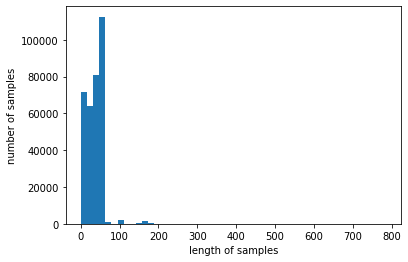

In [982]:
X_data = sequences
print('메일의 최대 길이 : %d' % max(len(l) for l in X_data))
print('메일의 평균 길이 : %f' % (sum(map(len, X_data))/len(X_data)))
plt.hist([len(s) for s in X_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [983]:
maxlen = max(len(l) for l in X_data)
maxlen

784

In [1017]:
maxlen = 50

In [1018]:
data = pad_sequences(sequences, maxlen=maxlen)

In [1019]:
#훈련 데이터 셋과 검증 데이터 셋으로 분리
TEST_SIZE=0.05
RANDOM_SEED=42

X_train, X_test, y_train, y_test = train_test_split(data, train_level, test_size=TEST_SIZE, random_state=RANDOM_SEED)


In [1020]:
X_train

array([[ 1,  1, 10, ...,  5,  7,  6],
       [ 1,  1, 10, ...,  5,  7,  6],
       [ 0,  0,  0, ..., 63, 22, 61],
       ...,
       [ 1,  1, 10, ...,  5,  7,  6],
       [ 1,  1, 10, ...,  5,  7,  6],
       [ 0,  0,  0, ..., 63, 22, 61]])

In [1021]:
train_df = pd.DataFrame(X_train)
train_df

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,1,1,10,5,7,6,36,1,39,1,...,33,32,20,21,34,9,10,5,7,6
1,1,1,10,5,7,6,36,1,39,1,...,33,32,20,21,34,9,10,5,7,6
2,0,0,0,0,0,0,0,0,0,23,...,2,44,41,4,55,58,62,63,22,61
3,1,1,10,5,7,6,36,1,39,1,...,33,32,20,21,34,9,10,5,7,6
4,1,1,10,5,7,6,36,1,39,1,...,33,32,20,21,34,9,10,5,7,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317356,1,1,10,5,7,6,36,1,39,1,...,33,32,20,21,34,9,10,5,7,6
317357,0,0,0,0,0,0,0,0,0,0,...,191,189,195,68,110,196,188,70,193,25
317358,1,1,10,5,7,6,36,1,39,1,...,33,32,20,21,34,9,10,5,7,6
317359,1,1,10,5,7,6,36,1,39,1,...,33,32,20,21,34,9,10,5,7,6


In [1022]:
columns = train_df.columns

In [1023]:
TAG_MIN = train_df[columns].min()
TAG_MAX = train_df[columns].max()

In [1024]:
def normalize(df):
    ndf = df.copy()
    for c in df.columns:
        if TAG_MIN[c] == TAG_MAX[c]:
            ndf[c] = df[c] - TAG_MIN[c]
        else:
            ndf[c] = (df[c] - TAG_MIN[c]) / (TAG_MAX[c] - TAG_MIN[c])
    return ndf

In [1025]:
X_train = normalize(train_df[columns])
X_train

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.00026,0.000265,0.002603,0.001301,0.001821,0.001561,0.009363,0.00026,0.010138,0.000253,...,0.008172,0.007923,0.004950,0.005197,0.008399,0.002234,0.002489,0.001252,0.001737,0.001252
1,0.00026,0.000265,0.002603,0.001301,0.001821,0.001561,0.009363,0.00026,0.010138,0.000253,...,0.008172,0.007923,0.004950,0.005197,0.008399,0.002234,0.002489,0.001252,0.001737,0.001252
2,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.005827,...,0.000495,0.010894,0.010149,0.000990,0.013587,0.014399,0.015431,0.015774,0.005458,0.015023
3,0.00026,0.000265,0.002603,0.001301,0.001821,0.001561,0.009363,0.00026,0.010138,0.000253,...,0.008172,0.007923,0.004950,0.005197,0.008399,0.002234,0.002489,0.001252,0.001737,0.001252
4,0.00026,0.000265,0.002603,0.001301,0.001821,0.001561,0.009363,0.00026,0.010138,0.000253,...,0.008172,0.007923,0.004950,0.005197,0.008399,0.002234,0.002489,0.001252,0.001737,0.001252
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317356,0.00026,0.000265,0.002603,0.001301,0.001821,0.001561,0.009363,0.00026,0.010138,0.000253,...,0.008172,0.007923,0.004950,0.005197,0.008399,0.002234,0.002489,0.001252,0.001737,0.001252
317357,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.047301,0.046794,0.048267,0.016828,0.027174,0.048659,0.046789,0.017526,0.047879,0.006009
317358,0.00026,0.000265,0.002603,0.001301,0.001821,0.001561,0.009363,0.00026,0.010138,0.000253,...,0.008172,0.007923,0.004950,0.005197,0.008399,0.002234,0.002489,0.001252,0.001737,0.001252
317359,0.00026,0.000265,0.002603,0.001301,0.001821,0.001561,0.009363,0.00026,0.010138,0.000253,...,0.008172,0.007923,0.004950,0.005197,0.008399,0.002234,0.002489,0.001252,0.001737,0.001252


In [1026]:
#훈련 데이터 셋과 검증 데이터 셋으로 분리
TEST_SIZE=0.15
RANDOM_SEED=42

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=TEST_SIZE, random_state=RANDOM_SEED)


In [1027]:
X_train.shape, X_val.shape

((269756, 50), (47605, 50))

In [1028]:
# X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
# X_train.shape
# X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
# X_val.shape

In [1029]:
def flatten(X):
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)


In [1030]:
# def conv_auto_model(x):

#     n_steps = x.shape[1]
#     n_features = x.shape[2]


#     model = Sequential(
#         [
#             Input(shape=(n_steps, n_features)),
#             Conv1D(filters=64, kernel_size=16, padding='same', data_format='channels_last',
#                           dilation_rate=1, activation="linear"),
#             Dense(32),
#             LSTM(
#                 units=32, activation="relu", name="lstm_1", return_sequences=False
#             ),
#             RepeatVector(n_steps),
#             Conv1D(filters=64, kernel_size=16, padding='same', data_format='channels_last',
#                 dilation_rate=1, activation="linear"),
#             Dense(32),
#             LSTM(
#                 units=32, activation="relu", name="lstm_2", return_sequences=True
#             ),

#             TimeDistributed(Dense(n_features, activation='linear'))
#         ]
#     )

#     model.summary()
#     return model

In [1031]:
def dnn(x):
    input_dim = x.shape[1]
    input = Input(shape=(input_dim, ))
    
    encode = Dense(x.shape[1], activation='relu')(input)
    #encode = Dense(128, activation='relu')(encode)
    encode = Dense(64, activation='relu')(encode)
    
    decode = Dense(64, activation='relu')(encode)
    #decode = Dense(128, activation='relu')(encode)
    decode = Dense(x.shape[1], activation='relu')(decode)

    autoencoder = Model(input, decode)

    autoencoder.summary()
    
    return autoencoder

In [1032]:
model = dnn(X_train)
model.compile(optimizer='adam', loss='mse')
#model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=5)
modelpath = "./model/0,1_{epoch:02d}-{val_loss:.4f}.hdf5"
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', 
                               verbose=1, save_best_only=True)


epochs = 10
batch = 64


Model: "model_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        [(None, 50)]              0         
_________________________________________________________________
dense_100 (Dense)            (None, 50)                2550      
_________________________________________________________________
dense_101 (Dense)            (None, 64)                3264      
_________________________________________________________________
dense_102 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_103 (Dense)            (None, 50)                3250      
Total params: 13,224
Trainable params: 13,224
Non-trainable params: 0
_________________________________________________________________


In [1033]:
# fit
history = model.fit(X_train, X_train,
                     epochs=epochs, batch_size=batch,
                     validation_data=(X_val, X_val), callbacks=[early_stopping, checkpointer])

Epoch 1/10
4215/4215 [==============================] - 4s 910us/step - loss: 7.5367e-05 - val_loss: 3.5104e-05

Epoch 00001: val_loss improved from inf to 0.00004, saving model to ./model\0,1_01-0.0000.hdf5
Epoch 2/10
4215/4215 [==============================] - 4s 839us/step - loss: 3.1774e-05 - val_loss: 2.6653e-05

Epoch 00002: val_loss improved from 0.00004 to 0.00003, saving model to ./model\0,1_02-0.0000.hdf5
Epoch 3/10
4215/4215 [==============================] - 4s 860us/step - loss: 2.5952e-05 - val_loss: 2.0316e-05

Epoch 00003: val_loss improved from 0.00003 to 0.00002, saving model to ./model\0,1_03-0.0000.hdf5
Epoch 4/10
4215/4215 [==============================] - 4s 864us/step - loss: 3.3619e-05 - val_loss: 2.3616e-05

Epoch 00004: val_loss did not improve from 0.00002
Epoch 5/10
4215/4215 [==============================] - 4s 909us/step - loss: 2.3898e-05 - val_loss: 2.6857e-05

Epoch 00005: val_loss did not improve from 0.00002
Epoch 6/10
4215/4215 [==================

In [1034]:
model = load_model('./model/0,1_10-0.0000.hdf5')

In [1035]:
val_sample = pd.read_csv('./data/mask_test2/mask_vaild.csv')
val_sample

,full_log,pre_log,first
0,type=ANOM_PROMISCUOUS msg=audit(1600402733.466...,type ANOM PROMISCUOUS msg audit dev enp prom o...,type ANOMPROMISCUOUS msg audit dev enp s prom ...
1,"oscap: msg: ""xccdf-result"", scan-id: ""00016007...",oscap msg xccdf result scan id content ssg cen...,oscap msg xccdfresult scanid content ssgcentos...
2,Sep 22 10:56:19 localhost kernel: Out of memor...,Sep localhost kernel Out of memory Kill proces...,Sep localhost kernel Out o


In [1036]:
# val_sample['full_log']=val_sample['full_log'].str.replace(r'[0-9]', '<num>')

In [1037]:
val_sample['pre_log']

0    type ANOM PROMISCUOUS msg audit dev enp prom o...
1    oscap msg xccdf result scan id content ssg cen...
2    Sep localhost kernel Out of memory Kill proces...
Name: pre_log, dtype: object

In [1038]:
# for i in val_sample['full_log']:
#     i = re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]', '', i)
# #     i = i.replace('Jan', '')
# #     i = i.replace('Feb', '')
# #     i = i.replace('Dec', '')
# #     i = i.replace('Sep', '')
# #     i = i.replace('Oct', '')
# #     i = i.replace('Nov', '')
# #     i = i.replace('Mar', '')

In [1039]:
val_smaple_data = tokenizer.texts_to_sequences(val_sample['pre_log'])
val_smaple_data = pad_sequences(val_smaple_data, maxlen=maxlen)

In [1040]:
val_smaple_data.shape

(3, 50)

In [1041]:

import pandas as pd
from numpy import vstack

# Combined x and x_test.
new_x = vstack([X_test, val_smaple_data])

In [1042]:
len(new_x)

16707

In [1043]:
new_x[-1:]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,   82,    4,  411,  321,
         377,  462,   20,  354,  112, 1248]])

In [1044]:
new_df = pd.DataFrame(new_x)
new_df

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,1,1,10,5,7,6,36,1,39,1,...,33,32,20,21,34,9,10,5,7,6
1,1,1,10,5,7,6,36,1,39,1,...,33,32,20,21,34,9,10,5,7,6
2,1,1,10,5,7,6,36,1,39,1,...,33,32,20,21,34,9,10,5,7,6
3,0,0,0,0,0,0,0,0,0,0,...,133,77,68,142,105,74,143,103,144,152
4,1,1,10,5,7,6,36,1,39,1,...,33,32,20,21,34,9,10,5,7,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16702,0,0,0,0,0,0,0,0,0,23,...,2,44,41,4,55,58,62,63,22,61
16703,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,23,4,11,97,145
16704,0,0,0,0,0,0,0,0,0,0,...,1082,281,12,1356,285,887,887,625,887,342
16705,41,695,259,1190,977,815,353,657,617,874,...,840,882,617,874,571,51,163,1035,1036,475


In [1045]:
new_x = normalize(new_df[columns])
new_x

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.000260,0.000265,0.002603,0.001301,0.001821,0.001561,0.009363,0.000260,0.010138,0.000253,...,0.008172,0.007923,0.004950,0.005197,0.008399,0.002234,0.002489,0.001252,0.001737,0.001252
1,0.000260,0.000265,0.002603,0.001301,0.001821,0.001561,0.009363,0.000260,0.010138,0.000253,...,0.008172,0.007923,0.004950,0.005197,0.008399,0.002234,0.002489,0.001252,0.001737,0.001252
2,0.000260,0.000265,0.002603,0.001301,0.001821,0.001561,0.009363,0.000260,0.010138,0.000253,...,0.008172,0.007923,0.004950,0.005197,0.008399,0.002234,0.002489,0.001252,0.001737,0.001252
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.032937,0.019064,0.016832,0.035140,0.025939,0.018371,0.035590,0.025789,0.035723,0.037807
4,0.000260,0.000265,0.002603,0.001301,0.001821,0.001561,0.009363,0.000260,0.010138,0.000253,...,0.008172,0.007923,0.004950,0.005197,0.008399,0.002234,0.002489,0.001252,0.001737,0.001252
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16702,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005827,...,0.000495,0.010894,0.010149,0.000990,0.013587,0.014399,0.015431,0.015774,0.005458,0.015023
16703,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.005710,0.000996,0.002754,0.024064,0.036054
16704,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.267954,0.069572,0.002970,0.335561,0.070405,0.220209,0.220757,0.156485,0.220045,0.085378
16705,0.010677,0.184252,0.067430,0.309735,0.254228,0.212019,0.091808,0.170827,0.160385,0.221434,...,0.208024,0.218371,0.152723,0.216283,0.141057,0.012661,0.040567,0.259139,0.257008,0.118678


In [1046]:
y_val2 = np.zeros(len(y_test)+3)
y_val2[-1] = 1
y_val2[-2] = 2
y_val2[-3] = 3

y_val2

array([0., 0., 0., ..., 3., 2., 1.])

In [1047]:
len(y_val2)

16707

In [1048]:
predictions = model.predict(new_x)

# Calculated MSE.
mse = np.mean(np.power(new_x - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse})


Text(0.5, 0, 'Data point index')

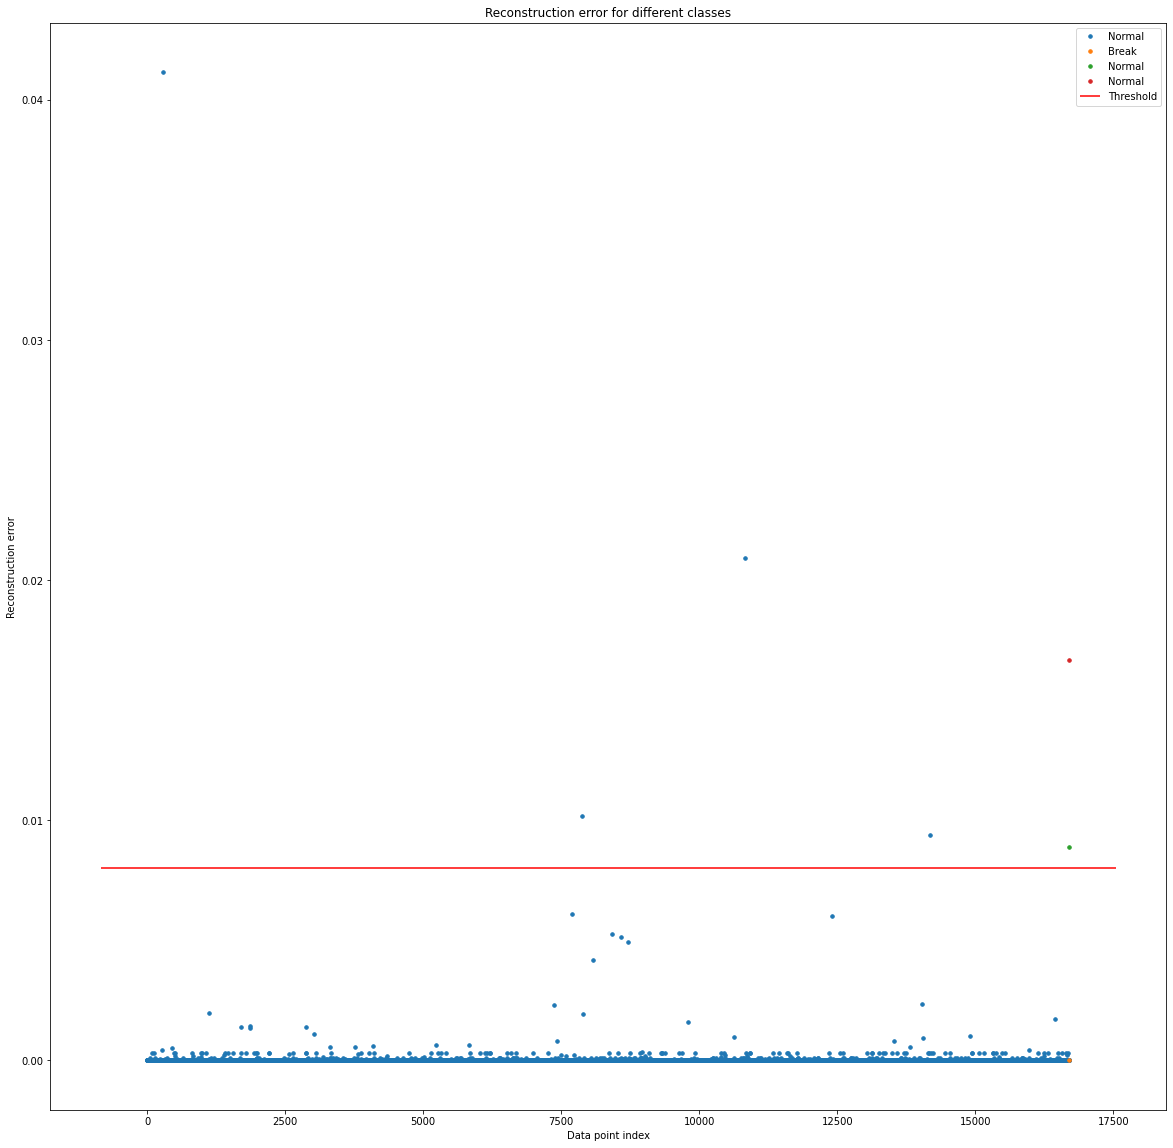

In [1050]:
test_error_df = pd.DataFrame({'Reconstruction_error': list(error_df['reconstruction_error']),
                         'True_class': list(y_val2)})
groups = test_error_df.groupby('True_class')
fig, ax = plt.subplots(figsize=(20,20))

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Break" if name == 1 else "Normal")
    
ax.hlines(0.008, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
#ax.hlines(0.001, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
#ax.hlines(3, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()

plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")

In [986]:
# #full_log에서 숫자는 마스킹 처리
# test['full_log']=test['full_log'].str.replace(r'[0-9]', '<num>')

In [1051]:
test = pd.read_csv('./data/mask_test2/mask_test.csv')


In [1052]:
test_data = tokenizer.texts_to_sequences(test['pre_log'])
test_data = sequence.pad_sequences(test_data, maxlen=maxlen)

In [1053]:
new_df = pd.DataFrame(test_data)
new_df

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,16,3,13,14,2,18,17,269,41,9,...,34,9,10,115,126,155,71,154,80,42
1,1,1,10,5,7,6,36,1,39,1,...,33,32,20,21,34,9,10,5,7,6
2,1701,1356,285,1701,675,3962,435,27,1027,2040,...,756,1597,888,12,1356,285,240,184,1861,811
3,1,1,10,5,7,6,36,1,39,1,...,33,32,20,21,34,9,10,5,7,6
4,0,0,0,0,12,1701,1356,285,1701,675,...,499,182,1597,12,1356,285,887,887,887,625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1418911,1,1,10,5,7,6,36,1,39,1,...,33,32,20,21,34,9,10,5,7,6
1418912,0,0,0,0,0,0,0,0,0,0,...,10,42,19,66,51,67,1,5,7,6
1418913,0,0,0,0,12,1701,1356,285,1701,675,...,182,1597,888,12,1356,285,240,184,1861,811
1418914,0,0,0,0,0,0,0,0,0,23,...,2,44,41,4,55,58,62,63,22,61


In [1054]:
test_data  =  normalize(new_df[columns])
test_data 

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.004167,0.000795,0.003385,0.003644,0.000520,0.004683,0.004421,0.069943,0.010658,0.002280,...,0.008420,0.002228,0.002475,0.028458,0.031126,0.038481,0.017670,0.038558,0.019846,0.010265
1,0.000260,0.000265,0.002603,0.001301,0.001821,0.001561,0.009363,0.000260,0.010138,0.000253,...,0.008172,0.007923,0.004950,0.005197,0.008399,0.002234,0.002489,0.001252,0.001737,0.001252
2,0.442969,0.359491,0.074199,0.442738,0.175644,1.030697,0.113134,0.007020,0.266961,0.516848,...,0.187221,0.395395,0.219802,0.002970,0.334980,0.070755,0.059731,0.046069,0.461672,0.202804
3,0.000260,0.000265,0.002603,0.001301,0.001821,0.001561,0.009363,0.000260,0.010138,0.000253,...,0.008172,0.007923,0.004950,0.005197,0.008399,0.002234,0.002489,0.001252,0.001737,0.001252
4,0.000000,0.000000,0.000000,0.000000,0.003123,0.442508,0.352666,0.074103,0.442163,0.171016,...,0.123576,0.045061,0.395297,0.002970,0.334980,0.070755,0.220757,0.222083,0.220045,0.156234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1418911,0.000260,0.000265,0.002603,0.001301,0.001821,0.001561,0.009363,0.000260,0.010138,0.000253,...,0.008172,0.007923,0.004950,0.005197,0.008399,0.002234,0.002489,0.001252,0.001737,0.001252
1418912,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.002476,0.010399,0.004703,0.016333,0.012599,0.016634,0.000249,0.001252,0.001737,0.001252
1418913,0.000000,0.000000,0.000000,0.000000,0.003123,0.442508,0.352666,0.074103,0.442163,0.171016,...,0.045072,0.395395,0.219802,0.002970,0.334980,0.070755,0.059731,0.046069,0.461672,0.202804
1418914,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005827,...,0.000495,0.010894,0.010149,0.000990,0.013587,0.014399,0.015431,0.015774,0.005458,0.015023


In [1055]:
predictions = model.predict(test_data )

# Calculated MSE.
mse = np.mean(np.power(test_data  - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse})


In [1056]:
error_df

,reconstruction_error
0,9.145495e-05
1,1.131936e-06
2,4.165595e-02
3,1.131936e-06
4,3.198275e-02
...,...
1418911,1.131937e-06
1418912,2.213794e-07
1418913,2.855396e-02
1418914,4.746182e-06


In [1070]:
pred_y_test = [1 if e > 0.065 else 0 for e in (error_df['reconstruction_error'].values)]
pred_y_test = np.array(pred_y_test)
pred_y_test.shape

(1418916,)

Text(0.5, 0, 'Data point index')

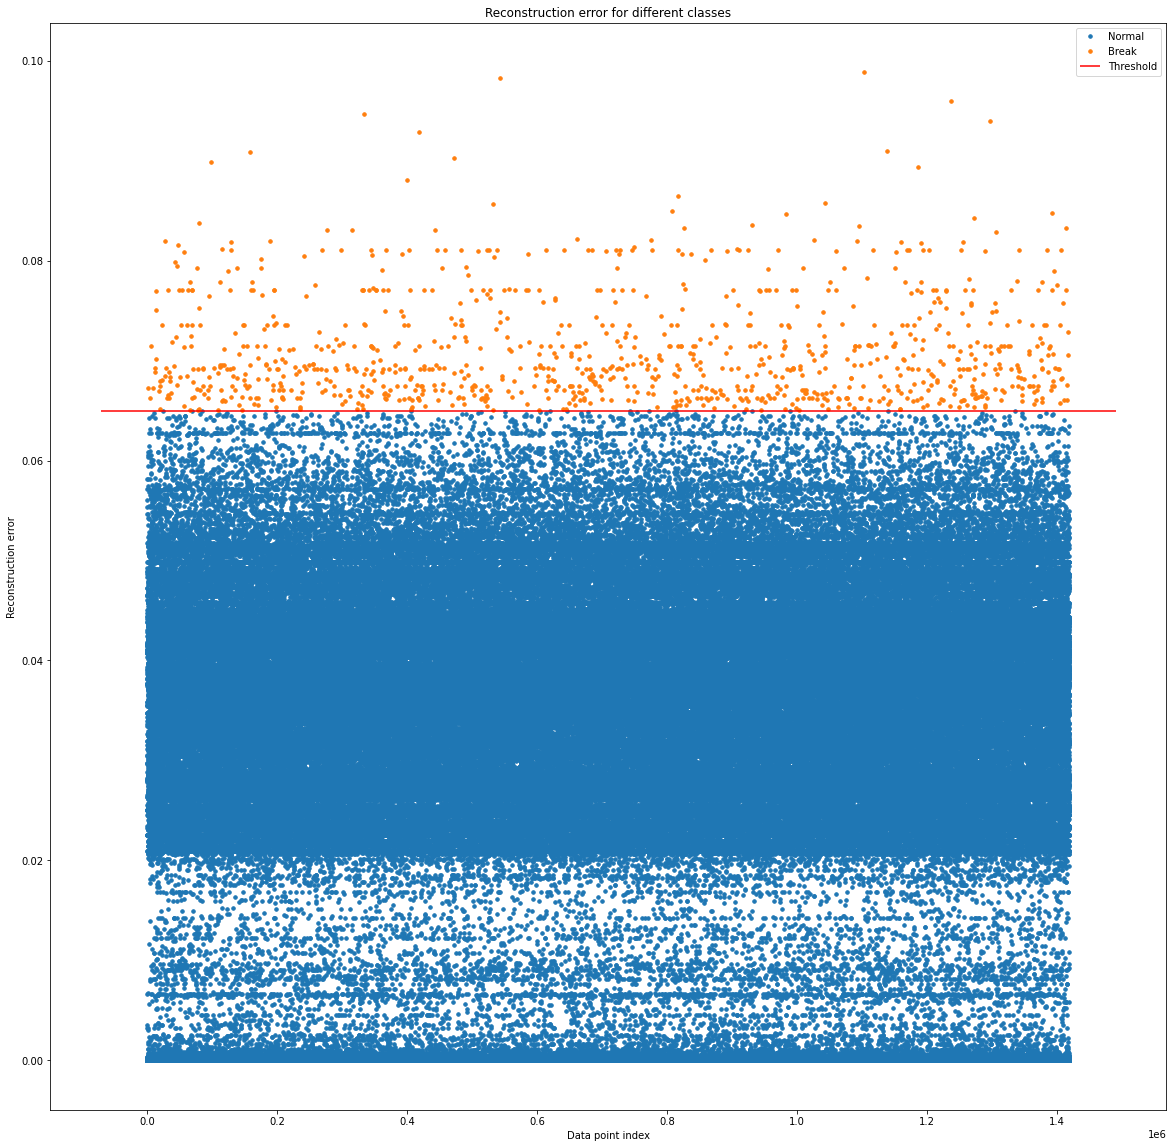

In [1071]:
test_error_df = pd.DataFrame({'Reconstruction_error': list(error_df['reconstruction_error']),
                         'True_class': list(pred_y_test)})
groups = test_error_df.groupby('True_class')
fig, ax = plt.subplots(figsize=(20,20))

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Break" if name == 1 else "Normal")
    
ax.hlines(0.065, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
#ax.hlines(0.001, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
#ax.hlines(3, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()

plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")

In [1072]:
test['predict'] = pred_y_test

In [1073]:
test

,id,full_log,pre_log,first,predict
0,1000000,"Feb 8 15:47:26 localhost kibana: {""type"":""err...",Feb localhost kibana type error timestamp Z ta...,...,0
1,1000001,"Sep 24 03:46:39 localhost kibana: {""type"":""err...",Sep localhost kibana type error timestamp Z ta...,...,0
2,1000002,type=SYSCALL msg=audit(1611888200.428:210563):...,type SYSCALL msg audit arch syscall success ye...,...,0
3,1000003,"Jan 18 11:24:06 localhost kibana: {""type"":""err...",Jan localhost kibana type error timestamp Z ta...,...,0
4,1000004,type=SYSCALL msg=audit(1603081202.050:46851): ...,type SYSCALL msg audit arch syscall success ye...,...,0
...,...,...,...,...,...
1418911,2418911,"Jan 13 05:07:11 localhost kibana: {""type"":""err...",Jan localhost kibana type error timestamp Z ta...,...,0
1418912,2418912,"Jan 5 02:24:50 localhost kibana: {""type"":""log...",Jan localhost kibana type log timestamp Z tags...,,0
1418913,2418913,type=SYSCALL msg=audit(1611884593.462:38222): ...,type SYSCALL msg audit arch syscall success ye...,...,0
1418914,2418914,Jan 22 01:38:19 localhost logstash: [2021-01-2...,Jan localhost logstash WARN logstash outputs e...,...,0


In [1074]:
test.to_csv('./test_type1.csv', index=False)

In [1075]:
submission['level']=pred_y_test

In [1076]:
submission

,id,level
0,1000000,0
1,1000001,0
2,1000002,0
3,1000003,0
4,1000004,0
...,...,...
1418911,2418911,0
1418912,2418912,0
1418913,2418913,0
1418914,2418914,0


In [1077]:
submission['level'].value_counts()

0    1417910
1       1006
Name: level, dtype: int64

In [1005]:
submission.to_csv('./auto_1183.csv', index=False)

In [477]:
idlist = submission['id'][submission['level']==0]
len(idlist)

1418780

In [478]:
model = load_model('./model/conv1d_04-0.0048.hdf5')

In [ ]:
model = load_model('./model/conv1d_04-0.0048.hdf5')